# Optimizacija hiperparametrov modela in korakov preprocesiranja

In [1]:
%run __A_knjiznice.py

# Import specific elements from the script
from __A_knjiznice import *
from __B_funkcije import *
import __C_konstante as kon
%matplotlib inline

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import logging
import optuna

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Load data
try:
    df = pd.read_csv(f'{kon.path_files}/molekulski_prstni_odtisi/df_circular.csv')
    y = df[['Activity']].values.ravel()  # Assuming 'Activity' is the target
    X = df.iloc[:, 3:]  # Assuming features start from the 4th column
except Exception as e:
    logger.error(f"Error loading data: {e}")
    exit()

# Split the data into interim and test sets
X_interim, X_test, y_interim, y_test = train_test_split(
    X, y, test_size=0.10, random_state=kon.random_seed, shuffle=True, stratify=y
)

# Split the interim data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_interim, y_interim, test_size=10/90, random_state=kon.random_seed, shuffle=True, stratify=y_interim
)

# Remove constant features after splitting the data
selector = VarianceThreshold()
X_train = pd.DataFrame(selector.fit_transform(X_train), columns=selector.get_feature_names_out())
X_val = pd.DataFrame(selector.transform(X_val), columns=selector.get_feature_names_out())
X_test = pd.DataFrame(selector.transform(X_test), columns=selector.get_feature_names_out())


# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters for SVC
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    # Hyperparameters for feature selection
    k = trial.suggest_int('k', 1, 500)  # Number of features to select

    # Create the pipeline
    steps = []
    steps.append(('under_sampler', RandomUnderSampler(random_state=kon.random_seed)))  # Add RandomUnderSampler
    steps.append(('feature_selection', SelectKBest(score_func=f_classif, k=k)))
    steps.append(('classifier', SVC(C=C, kernel=kernel, gamma=gamma, random_state=kon.random_seed)))

    pipeline = ImbPipeline(steps)

    # Train the model on the training set
    pipeline.fit(X_train, y_train)

    # Evaluate the model on the validation set
    y_val_pred = pipeline.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    # Log the validation accuracy
    logger.info(f"Trial {trial.number}: Validation Accuracy = {val_accuracy:.4f}")
    
    return val_accuracy

# Run Optuna to find the best hyperparameters
study = optuna.create_study(
    direction='maximize', 
    sampler=optuna.samplers.TPESampler(seed=kon.random_seed)
)

study.optimize(objective, n_trials=50)

# Get the best parameters from Optuna
best_params = study.best_params
logger.info(f"Best parameters from Optuna: {best_params}")

# Train the final model with the best parameters
final_steps = []
final_steps.append(('under_sampler', RandomUnderSampler(random_state=kon.random_seed)))  # Add RandomUnderSampler
final_steps.append(('feature_selection', SelectKBest(score_func=f_classif, k=best_params['k'])))
final_steps.append(('classifier', SVC(
    C=best_params['C'],
    kernel=best_params['kernel'],
    gamma=best_params['gamma'],
    random_state=kon.random_seed
)))

final_pipeline = ImbPipeline(final_steps)
final_pipeline.fit(X_train, y_train)

# Evaluate the model on the validation set
y_val_pred = final_pipeline.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
logger.info(f"Final Validation Accuracy: {val_accuracy:.4f}")

[I 2024-12-23 00:11:27,144] A new study created in memory with name: no-name-bcc2feae-fed2-4d86-b782-ca903c498e0b
2024-12-23 00:11:27,423 - INFO - Trial 0: Validation Accuracy = 0.8096
[I 2024-12-23 00:11:27,424] Trial 0 finished with value: 0.8096385542168675 and parameters: {'C': 10.806158960159818, 'kernel': 'poly', 'gamma': 'scale', 'k': 24}. Best is trial 0 with value: 0.8096385542168675.
2024-12-23 00:11:27,752 - INFO - Trial 1: Validation Accuracy = 0.8988
[I 2024-12-23 00:11:27,752] Trial 1 finished with value: 0.8987951807228916 and parameters: {'C': 878.5457796416958, 'kernel': 'poly', 'gamma': 'auto', 'k': 198}. Best is trial 1 with value: 0.8987951807228916.
2024-12-23 00:11:28,242 - INFO - Trial 2: Validation Accuracy = 0.8699
[I 2024-12-23 00:11:28,242] Trial 2 finished with value: 0.8698795180722891 and parameters: {'C': 697.8109514299433, 'kernel': 'rbf', 'gamma': 'scale', 'k': 409}. Best is trial 1 with value: 0.8987951807228916.
2024-12-23 00:11:28,443 - INFO - Trial 

In [3]:
from itertools import product
import numpy as np
import pandas as pd
from sklearn.svm import SVC  # Import SVC for Support Vector Machine
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Define a grid search based on the best parameters found
param_grid = {
    'C': [
        max(1e-3, best_params['C'] * 0.9),  # Lower bound: 90% of the value
        best_params['C'],
        best_params['C'] * 1.1  # Upper bound: 110% of the value
    ],
    'kernel': [best_params['kernel']],  # Keeping the best kernel
    'gamma': [
        best_params['gamma'],  # Keeping the best gamma
        'scale',  # Adding 'scale' as an option
        'auto'   # Adding 'auto' as an option
    ],
    'k': [
        max(1, int(best_params['k'] * 0.9)),  # Lower bound: 90% of the best k
        best_params['k'],                      # Best k
        min(X_train.shape[1], int(best_params['k'] * 1.1))  # Upper bound: 110% of the best k, capped at max features
    ]
}

# Create a list of all combinations of parameters for grid search
param_combinations = list(product(
    param_grid['C'],
    param_grid['kernel'],
    param_grid['gamma'],
    param_grid['k']
))

# Function to evaluate a single set of parameters
def evaluate_model(params):
    C, kernel, gamma, k = params
    
    # Feature selection
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)
    
    svm = SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
        random_state=kon.random_seed
    )
    
    try:
        # Perform cross-validation
        cv_scores = cross_val_score(svm, X_train_selected, y_train, cv=5, scoring='accuracy')
        cv_accuracy = np.mean(cv_scores)
        
        # Fit the model on the full training set
        svm.fit(X_train_selected, y_train)
        
        # Evaluate on the validation set
        y_val_pred = svm.predict(X_val_selected)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        return {
            "Parameters": {
                "C": C,
                "kernel": kernel,
                "gamma": gamma,
                "k": k
            },
            "CV Accuracy": cv_accuracy,
            "Validation Accuracy": val_accuracy
        }
    except Exception as e:
        logger.error(f"Error with parameters {params}: {e}")
        return None

# Sequentially evaluate the models using grid search
results = []
for params in param_combinations:
    result = evaluate_model(params)
    if result is not None:  # Only append valid results
        results.append(result)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Sort the results DataFrame by Validation Accuracy in descending order
sorted_results_df = results_df.sort_values(by='Validation Accuracy', ascending=False)

# Log the best result
if not sorted_results_df.empty:
    best_result = sorted_results_df.iloc[0]  # Get the first row after sorting
    logger.info(f"Best Parameters: {best_result['Parameters']}, CV Accuracy: {best_result['CV Accuracy']}, Validation Accuracy: {best_result['Validation Accuracy']}")
else:
    logger.warning("No valid results were found during the grid search.")

2024-12-23 00:13:42,742 - INFO - Best Parameters: {'C': 830.953708438151, 'kernel': 'poly', 'gamma': 'auto', 'k': 250}, CV Accuracy: 0.8722860931497861, Validation Accuracy: 0.9012048192771084


In [4]:
sorted_results_df

,Parameters,CV Accuracy,Validation Accuracy
0,"{'C': 830.953708438151, 'kernel': 'poly', 'gam...",0.872286,0.901205
11,"{'C': 923.2818982646122, 'kernel': 'poly', 'ga...",0.869572,0.901205
25,"{'C': 1015.6100880910735, 'kernel': 'poly', 'g...",0.876213,0.901205
24,"{'C': 1015.6100880910735, 'kernel': 'poly', 'g...",0.874098,0.901205
20,"{'C': 1015.6100880910735, 'kernel': 'poly', 'g...",0.872290,0.901205
19,"{'C': 1015.6100880910735, 'kernel': 'poly', 'g...",0.876213,0.901205
18,"{'C': 1015.6100880910735, 'kernel': 'poly', 'g...",0.874098,0.901205
17,"{'C': 923.2818982646122, 'kernel': 'poly', 'ga...",0.869572,0.901205
16,"{'C': 923.2818982646122, 'kernel': 'poly', 'ga...",0.872893,0.901205
15,"{'C': 923.2818982646122, 'kernel': 'poly', 'ga...",0.874399,0.901205


In [5]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline  # Use Imbalanced Pipeline from imblearn
from sklearn.feature_selection import SelectKBest, f_classif

# Assuming the best parameters are already identified from Optuna or grid search
best_params = sorted_results_df.iloc[0]['Parameters']

# Define the pipeline
pipeline = Pipeline([
    ('under_sampler', RandomUnderSampler(random_state=kon.random_seed)),  # Step 1: Handle class imbalance
    ('feature_selection', SelectKBest(score_func=f_classif, k=best_params['k'])),  # Step 2: Feature selection
    ('svc', SVC(
        C=best_params['C'],
        kernel=best_params['kernel'],
        gamma=best_params['gamma'],
        probability=True,  # Enable probability estimates for ROC AUC
        random_state=kon.random_seed
    ))  # Step 3: SVM classifier
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# --- Evaluation on Training Data ---
y_train_pred = pipeline.predict(X_train)
y_train_prob = pipeline.predict_proba(X_train)[:, 1]  # Get probabilities for the positive class
auc_train_score = roc_auc_score(y_train, y_train_prob)
conf_matrix_train = confusion_matrix(y_train, y_train_pred)

# --- Evaluation on Validation Data ---
y_val_pred = pipeline.predict(X_val)
y_val_prob = pipeline.predict_proba(X_val)[:, 1]  # Get probabilities for the positive class
auc_val_score = roc_auc_score(y_val, y_val_prob)
conf_matrix_val = confusion_matrix(y_val, y_val_pred)

# --- Evaluation on Test Data ---
y_test_pred = pipeline.predict(X_test)
y_test_prob = pipeline.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
auc_test_score = roc_auc_score(y_test, y_test_prob)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# --- Print the Results ---
print(f"AUC Train Score: {auc_train_score:.4f}")
print(f"AUC Validation Score: {auc_val_score:.4f}")
print(f"AUC Test Score: {auc_test_score:.4f}")

print("Confusion Matrix (Train):")
print(conf_matrix_train)

print("Confusion Matrix (Validation):")
print(conf_matrix_val)

print("Confusion Matrix (Test):")
print(conf_matrix_test)

AUC Train Score: 0.9863
AUC Validation Score: 0.9414
AUC Test Score: 0.9428
Confusion Matrix (Train):
[[1548   83]
 [ 147 1534]]
Confusion Matrix (Validation):
[[183  21]
 [ 20 191]]
Confusion Matrix (Test):
[[181  23]
 [ 22 189]]


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Plotting the confusion matrix
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


# Updated ROC Curve Plotting Function
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    auc_score_dynamic = roc_auc_score(y_true, y_prob)  # Calculate AUC for current data
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(auc_score_dynamic))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

Training Accuracy: 0.9305555555555556
Training F1 Score: 0.9302607640994542
Training Precision: 0.9486703772418058
Training Recall: 0.9125520523497918


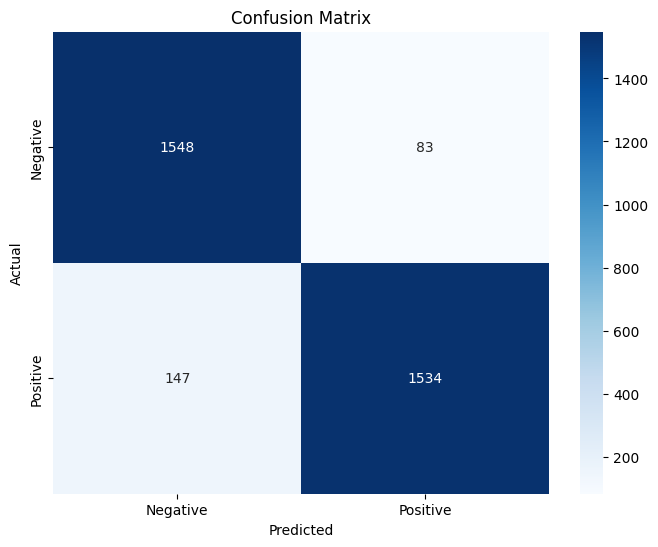

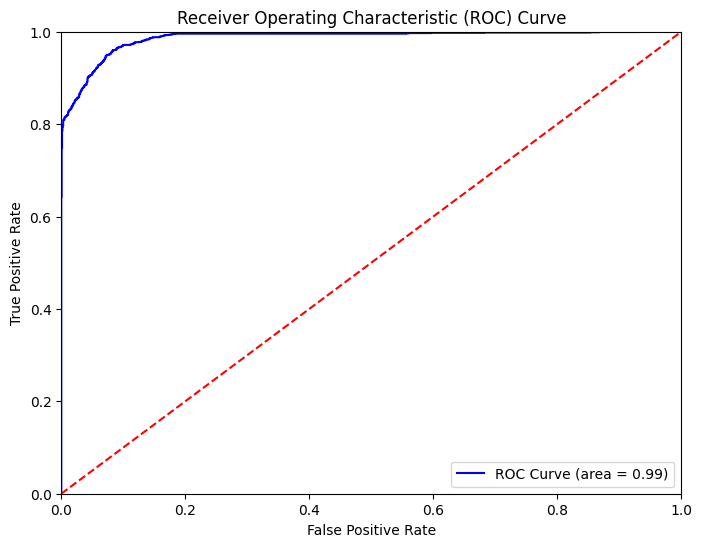

In [7]:
accuracy_train = accuracy_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)

print("Training Accuracy:", accuracy_train)
print("Training F1 Score:", f1_train)
print("Training Precision:", precision_train)
print("Training Recall:", recall_train)
# Plotting the confusion matrix for training data
plot_confusion_matrix(conf_matrix_train)
plot_roc_curve(y_train, y_train_prob)

Validation Accuracy: 0.9012048192771084
Validation F1 Score: 0.9030732860520094
Validation Precision: 0.9009433962264151
Validation Recall: 0.9052132701421801


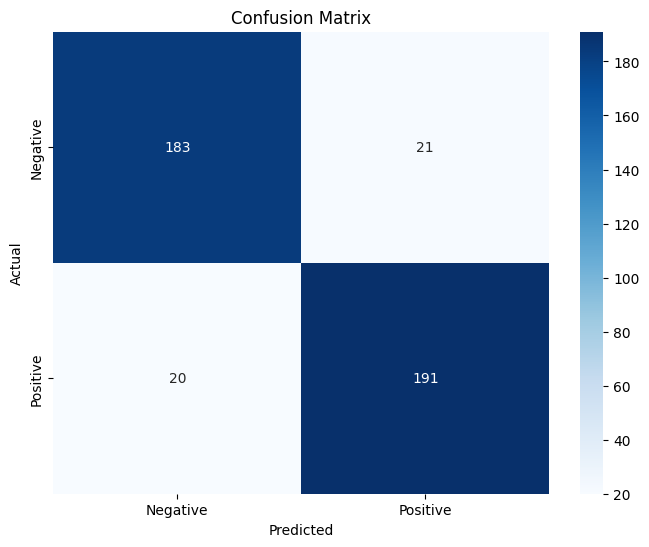

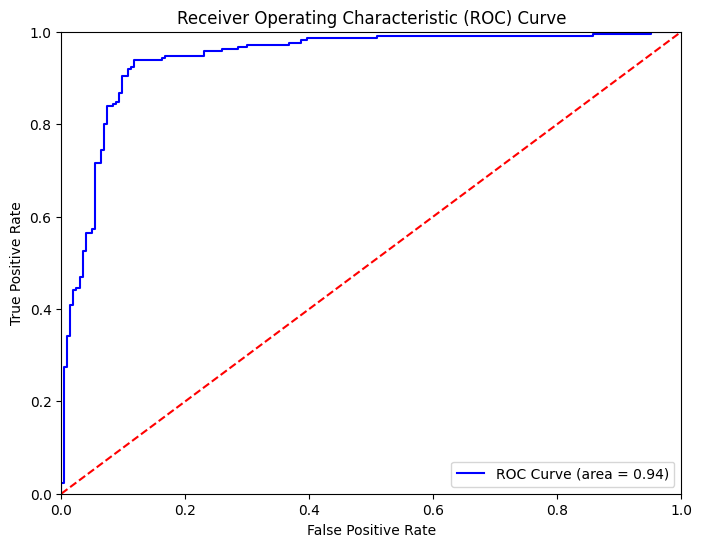

In [8]:
# Calculate metrics for validation data
accuracy_val = accuracy_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)

print("Validation Accuracy:", accuracy_val)
print("Validation F1 Score:", f1_val)
print("Validation Precision:", precision_val)
print("Validation Recall:", recall_val)

# Plotting the confusion matrix for validation data
plot_confusion_matrix(conf_matrix_val)
plot_roc_curve(y_val, y_val_prob)

# Pregled rezulatov na podatkih za testiranje

Test Accuracy: 0.891566265060241
Test F1 Score: 0.8936170212765957
Test Precision: 0.8915094339622641
Test Recall: 0.8957345971563981


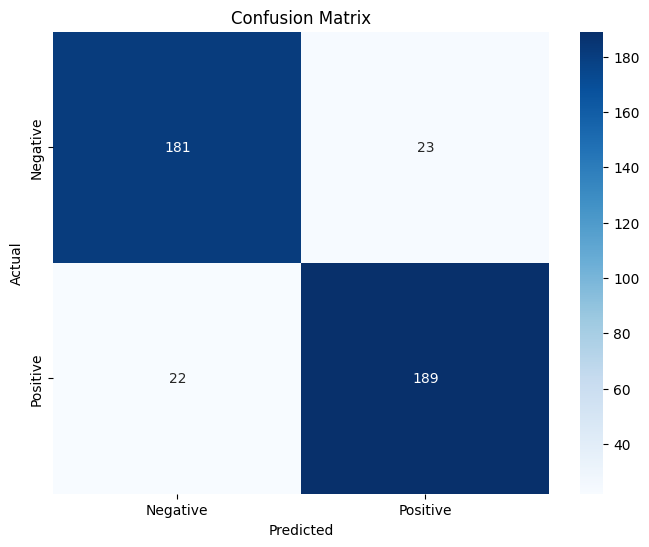

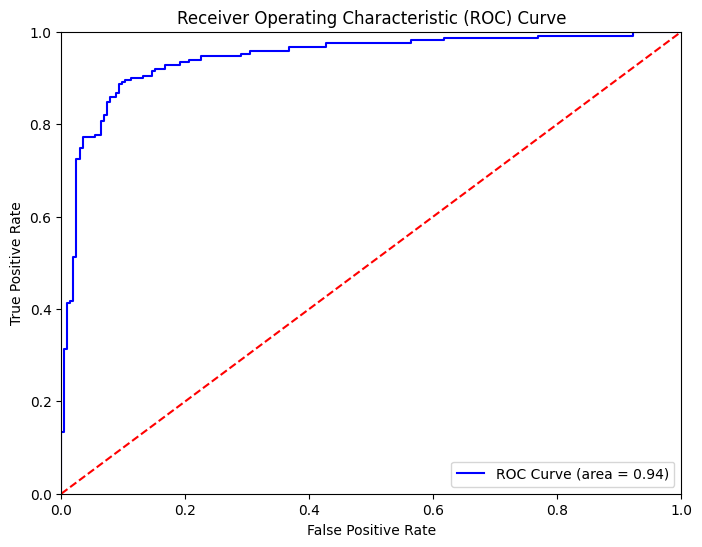

In [9]:
# Calculate metrics for test data
accuracy_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)

print("Test Accuracy:", accuracy_test)
print("Test F1 Score:", f1_test)
print("Test Precision:", precision_test)
print("Test Recall:", recall_test)

plot_confusion_matrix(conf_matrix_test)
plot_roc_curve(y_test, y_test_prob)
